In [33]:
import nibabel as nib
import os

from monai.data import (
    Dataset,
)

from monai.transforms import (
    Compose,
    LoadImaged,
)

from met_brewer import met_brew
from tqdm import tqdm
import glob
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline


 missing cuda symbols while dynamic loading
 cuFile initialization failed


In [35]:
transforms = Compose(
            [
                LoadImaged(keys=["image", "label"], image_only=False),
                ]
)

In [185]:
data_dir = "/data/Dataset060_Merged_Def/"
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))

data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

df = Dataset(
    data=data_dicts,
    transform=transforms,
)

In [187]:
len(df)

680

## Data Extraction

In [189]:
image_sizes = []
image_dims = []
image_orientations = []
image_num_slices = []
image_slice_thickness = []

for image in tqdm(df):
    img = image['image']
    img_meta = image['image_meta_dict']
    
    image_sizes.append(list(img.shape))
    image_dims.append(list(img_meta['pixdim'][1:4]))
    image_orientations.append(img_meta['space'])
    image_num_slices.append(img.shape[-1])
    image_slice_thickness.append(img_meta['pixdim'][3])

np.save('/data_analysis/merged_dataset/data_saves/image_size_variability.npy', image_sizes)
np.save('/data_analysis/merged_dataset/data_saves/inplane_resolution.npy', image_dims)
np.save('/data_analysis/merged_dataset/data_saves/image_orientations.npy', image_orientations)
np.save('/data_analysis/merged_dataset/data_saves/image_slice_thickness.npy', image_slice_thickness)
np.save('/data_analysis/merged_dataset/data_saves/image_num_slices.npy', image_num_slices)

100%|██████████| 680/680 [17:31<00:00,  1.55s/it]


## Load data

In [213]:
image_sizes = np.load('data_saves/image_size_variability.npy')
image_dims = np.load('data_saves/inplane_resolution.npy')
image_orientations = np.load('data_saves/image_orientations.npy')
image_slice_thickness = np.load('data_saves/image_slice_thickness.npy')
image_num_slices = np.load('data_saves/image_num_slices.npy')

## Image Size Variability

In [190]:
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]
depths = [size[2] for size in image_sizes]

In [191]:
mean_width = np.mean(widths)
std_width = np.std(widths)
mean_height = np.mean(heights)
std_height = np.std(heights)
mean_depth = np.mean(depths)
std_depth = np.std(depths)

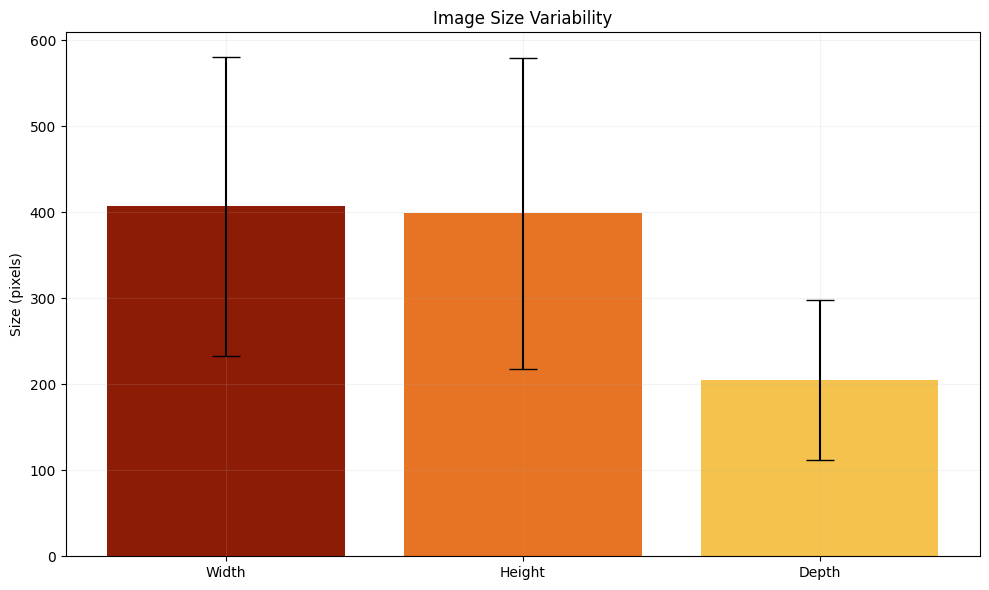

In [192]:
dimensions = ['Width', 'Height', 'Depth']
means = [mean_width, mean_height, mean_depth]
std_devs = [std_width, std_height, std_depth]

x_pos = np.arange(len(dimensions))

colors = met_brew(name="Greek", n=3, brew_type="colorblind")

plt.figure(figsize=(10, 6))
plt.bar(x_pos, means, yerr=std_devs, align='center', capsize=10, color=colors)
plt.xticks(x_pos, dimensions)
plt.ylabel('Size (pixels)')
plt.title('Image Size Variability')
plt.grid(True, alpha=0.15)
plt.tight_layout()

plt.show()

## In-plane Resolution

In [12]:
xs = [dim[0] for dim in image_dims]
ys = [dim[1] for dim in image_dims]
zs = [dim[2] for dim in image_dims]

In [13]:
mean_x = np.mean(xs)
std_x = np.std(xs)
mean_y = np.mean(ys)
std_y = np.std(ys)
mean_z = np.mean(zs)
std_z = np.std(zs)

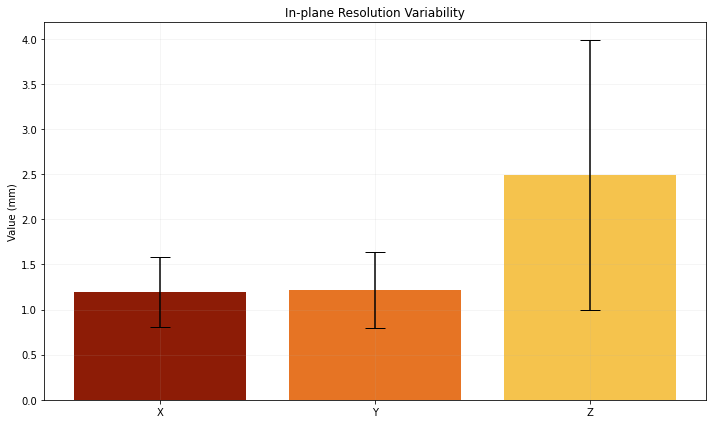

In [14]:
dimensions = ['X', 'Y', 'Z']
means = [mean_x, mean_y, mean_z]
std_devs = [std_x, std_y, std_z]

x_pos = np.arange(len(dimensions))

colors = met_brew(name="Greek", n=3, brew_type="colorblind")

plt.figure(figsize=(10, 6))
plt.bar(x_pos, means, yerr=std_devs, align='center', capsize=10, color=colors)
plt.xticks(x_pos, dimensions)
plt.ylabel('Value (mm)')
plt.title('In-plane Resolution Variability')
plt.tight_layout()
plt.grid(True, alpha=0.15)
plt.show()

## Orientation

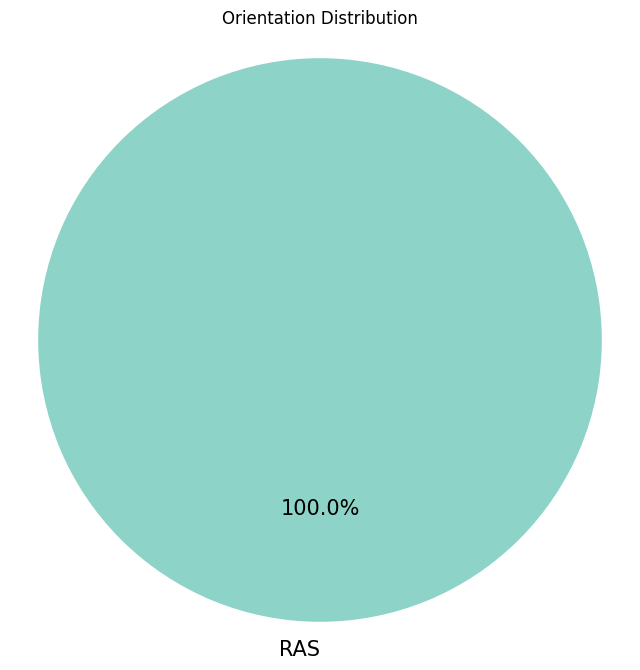

In [83]:
orientation_counts = {str(orientation): orientation_count for orientation, orientation_count in np.asarray(np.unique(image_orientations, return_counts=True)).T}

orientation_labels = list(orientation_counts.keys())
orientation_values = list(orientation_counts.values())

plt.figure(figsize=(8, 8))
plt.pie(orientation_values, labels=orientation_labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3(range(len(orientation_labels))), textprops={'fontsize': 15})
plt.title('Orientation Distribution')
plt.axis('equal')
plt.show()

## Slice Count

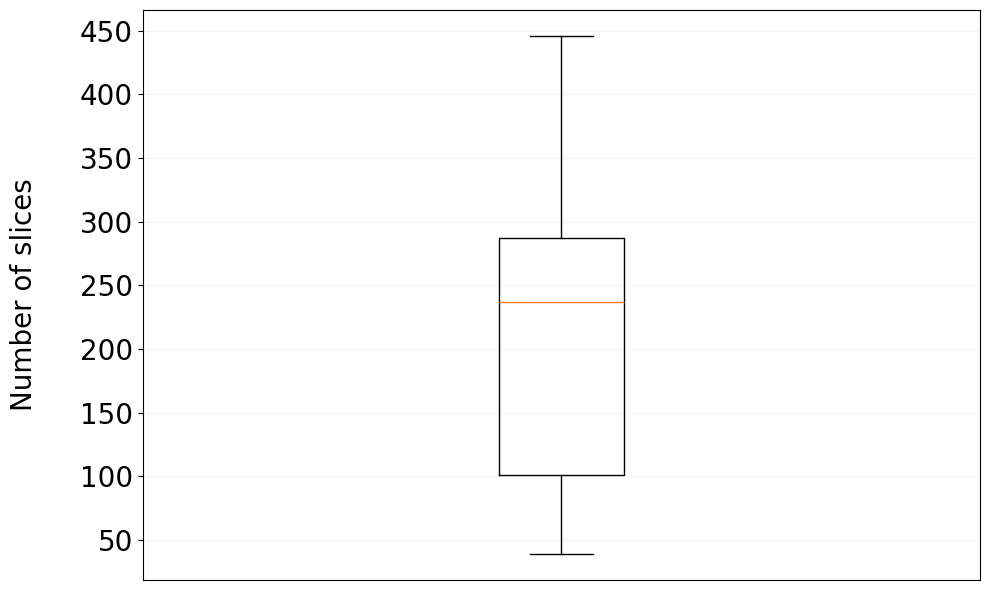

In [214]:
fontsize = 20

plt.figure(figsize=(10, 6))
bp = plt.boxplot(image_num_slices, showfliers=True)
plt.ylabel('Number of slices', fontsize=fontsize, labelpad=30)

plt.xticks([])
plt.yticks(fontsize=fontsize)
plt.grid(True,  alpha=0.15)
plt.tight_layout()

plt.show()

In [216]:
whiskers = [item.get_ydata() for item in bp['whiskers']]
caps = [item.get_ydata() for item in bp['caps']]
boxes = [item.get_ydata() for item in bp['boxes']]
medians = [item.get_ydata() for item in bp['medians']]
fliers = [item.get_ydata() for item in bp['fliers']]

print(f"Whiskers: {whiskers}")
print(f"Caps: {caps}")
print(f"Boxes (Q1 and Q3): {boxes}")
print(f"Medians: {medians}")
print(f"Fliers (Outliers): {fliers}")

Whiskers: [array([101.,  39.]), array([287., 446.])]
Caps: [array([39, 39]), array([446, 446])]
Boxes (Q1 and Q3): [array([101., 101., 287., 287., 101.])]
Medians: [array([237., 237.])]
Fliers (Outliers): [array([], dtype=int64)]


## Slice Thickness

In [205]:
image_slice_thickness = list(image_slice_thickness)

In [206]:
thickness_counts

{'1.25': 4, '2.0': 63, '2.5': 6, '3.0': 17, '5.0': 212, '1.5': 378}

Number of requested colors ('6') greater than number of colors 'Java' can offer. 
 Setting brew_type to 'continuous' instead.


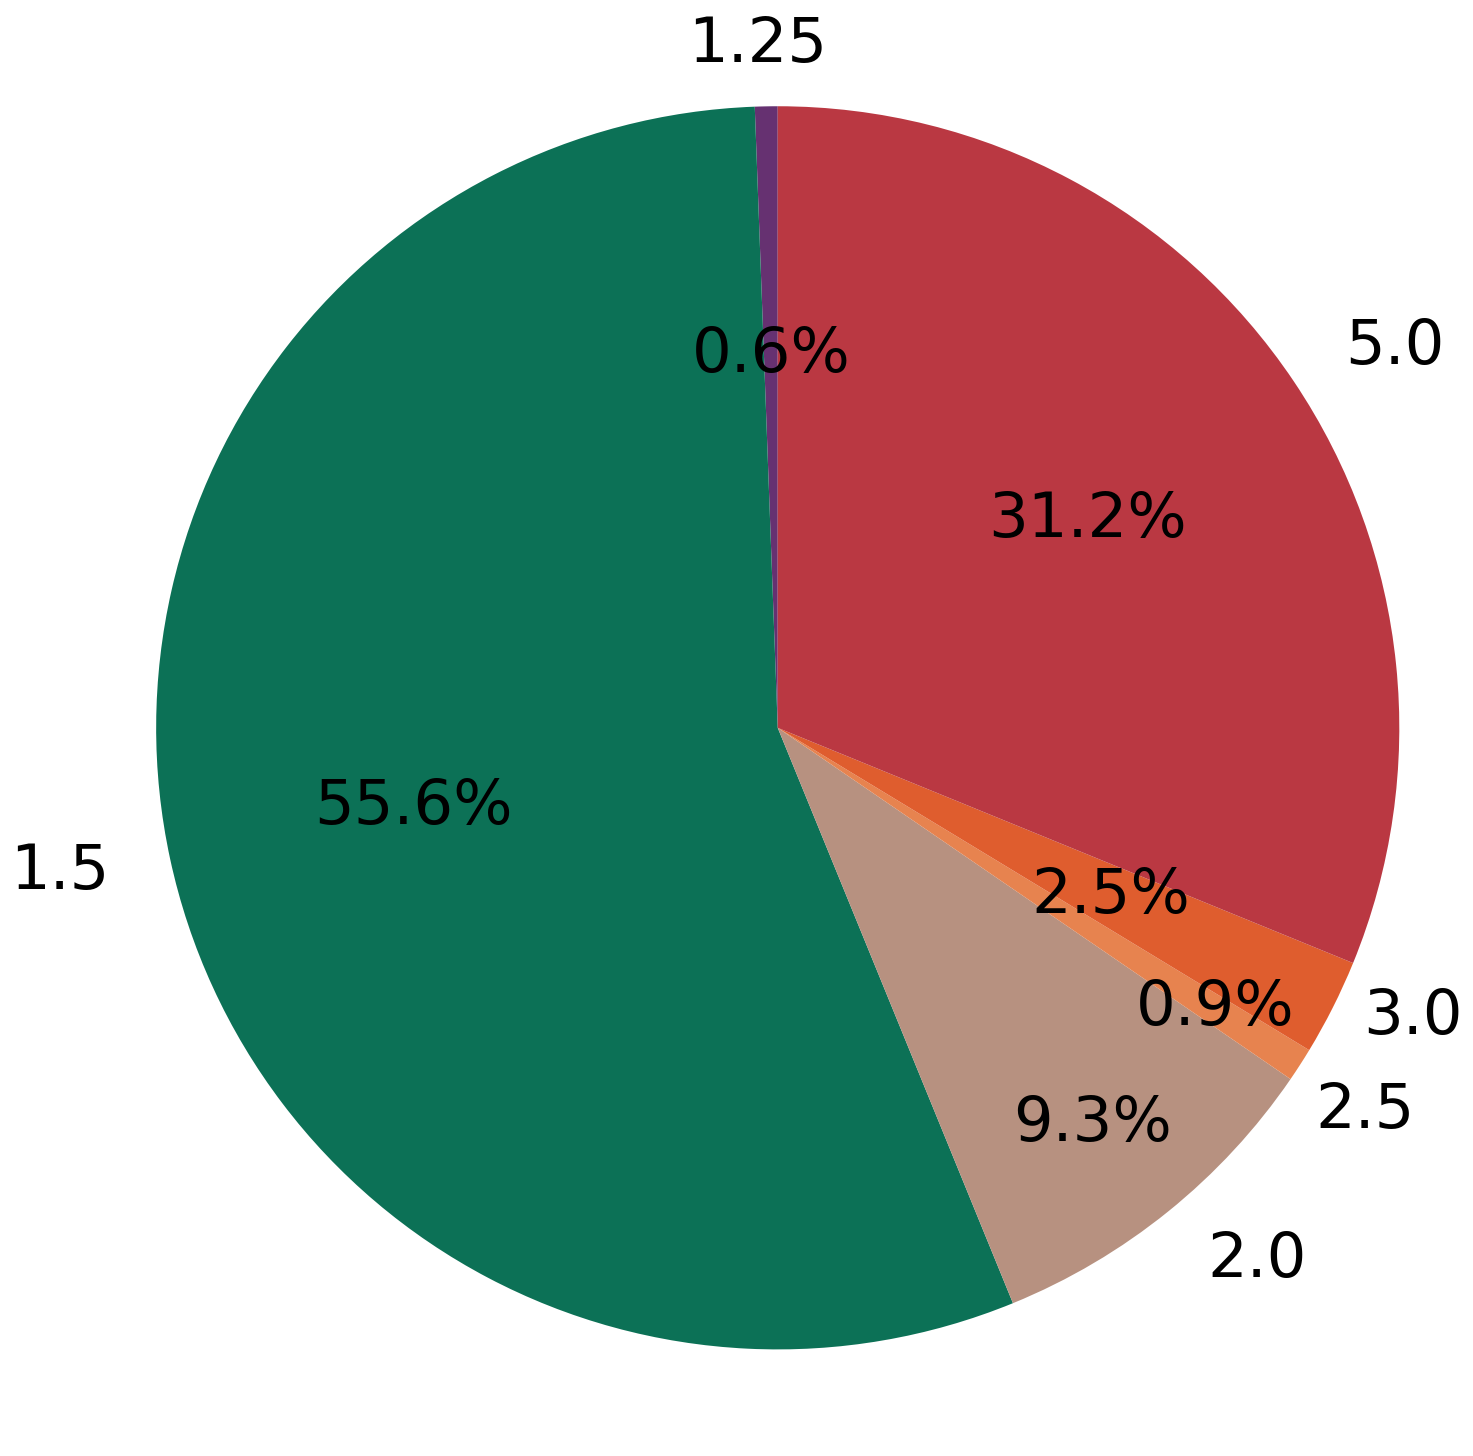

In [207]:
fontsize = 45

thickness_counts = {str(thickness): image_slice_thickness.count(thickness) for thickness in set(image_slice_thickness)}

thickness_counts['1.25'] = thickness_counts['1.25']

thickness_counts['1.5'] = thickness_counts['1.5'] + thickness_counts['1.4999999'] + thickness_counts['1.5000001']
thickness_counts.pop('1.4999999', None)
thickness_counts.pop('1.5000001', None)

thickness_counts['2.0'] = thickness_counts['2.0']

thickness_counts['3.0'] = thickness_counts['3.0']

thickness_counts['5.0'] = thickness_counts['5.0'] + thickness_counts['5.0000005']
thickness_counts.pop('5.0000005', None)

od = sorted(thickness_counts.items())

colors = met_brew(name="Java", n=len(od), brew_type="colorblind")

plt.figure(figsize=(15, 15))
_, labels, pie = plt.pie([o[1] for o in od], labels=[o[0] for o in od], autopct='%1.1f%%', pctdistance=0.6, colors=colors[::-1][-1:]+colors[::-1][:-1], startangle=90, textprops={'weight':'normal', 'fontsize': fontsize})

pie[2].set_y(np.array(pie[2].get_position())[1]-0.18)
pie[2].set_x(np.array(pie[2].get_position())[0]+ 0.18)

pie[2].set_y(np.array(pie[2].get_position())[1]+0.01)
pie[2].set_x(np.array(pie[2].get_position())[0]-0.05)

pie[3].set_y(np.array(pie[3].get_position())[1]-0.125)
pie[3].set_x(np.array(pie[3].get_position())[0]+0.2)

labels[0].set_x(np.array(labels[0].get_position())[0]+0.1)

labels[3].set_x(np.array(labels[3].get_position())[0]-0.06)
labels[3].set_y(np.array(labels[3].get_position())[1]-0.02)

labels[4].set_x(np.array(labels[4].get_position())[0]-0.04)
labels[4].set_y(np.array(labels[4].get_position())[1]+0.03)

plt.setp(pie, **{'weight':'normal', 'fontsize':fontsize})
plt.axis('equal')
plt.tight_layout()

plt.show()

In [208]:
{str(thickness): image_slice_thickness.count(thickness) for thickness in set(image_slice_thickness)}

{'1.25': 4,
 '2.0': 63,
 '2.5': 6,
 '3.0': 17,
 '5.0000005': 1,
 '5.0': 211,
 '1.5': 373,
 '1.5000001': 4,
 '1.4999999': 1}

In [209]:
thickness_1 = []
thickness_15 = []
thickness_2 = []
thickness_25 = []
thickness_3 = []
thickness_5 = []

for i, thickness in enumerate(image_slice_thickness):
    if float(thickness) < 1.5:
        thickness_1.append(image_num_slices[i])
    elif abs(float(thickness) - 1.5) < 0.3:
        thickness_15.append(image_num_slices[i])
    elif abs(float(thickness) - 2.0) < 0.3:
        thickness_2.append(image_num_slices[i])
    elif str(thickness) == str(2.5):
        thickness_25.append(image_num_slices[i])
    elif abs(float(thickness) - 3.0) < 0.3:
        thickness_3.append(image_num_slices[i])
    elif abs(float(thickness) - 5.0) < 0.3:
        thickness_5.append(image_num_slices[i])

In [210]:
yticks

['1.25', '1.5', '2.0', '2.5', '3.0', '5.0']

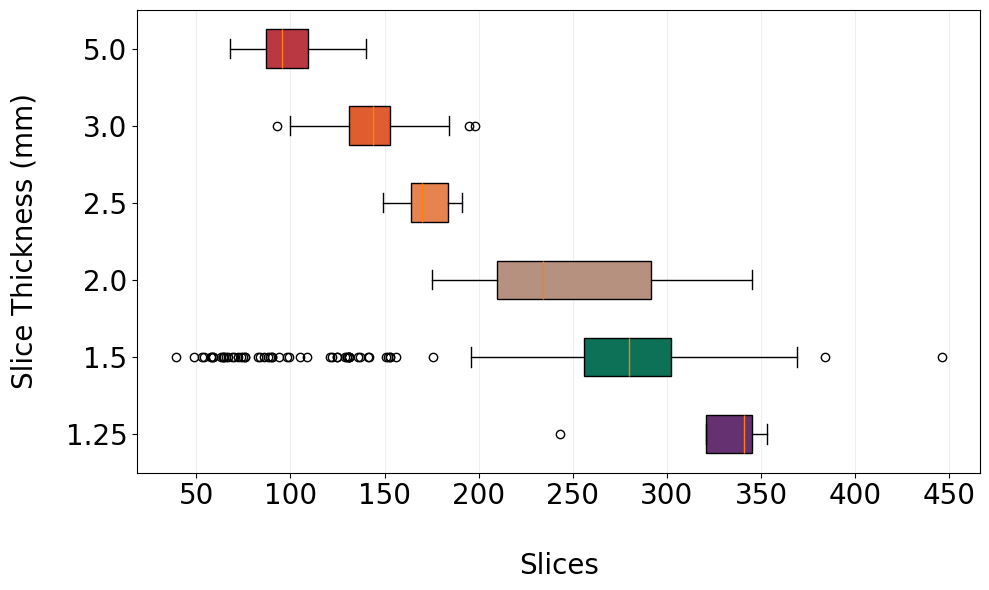

In [212]:
fontsize = 20

plt.figure(figsize=(10, 6))
bplot = plt.boxplot([thickness_1, thickness_15, thickness_2, thickness_25, thickness_3, thickness_5], showfliers=True, vert=False, patch_artist=True)
plt.xlabel('Slices', fontsize=fontsize, labelpad=30)
plt.ylabel('Slice Thickness (mm)', fontsize=fontsize, labelpad=20)

yticks = list([o[0] for o in od])

plt.yticks(range(1, len([o[0] for o in od])+1), yticks, fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.grid(True, alpha=0.2, axis='x')

for c, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(colors[::-1][c-1])

plt.tight_layout()

plt.show()

## Sex Distribution

In [1]:
amos_metadata = pd.read_csv('/data_analysis/amos/amos_metadata_def.csv')
totalseg_metadata = pd.read_csv('/data_analysis/totalseg/totalseg_metadata_def.csv')

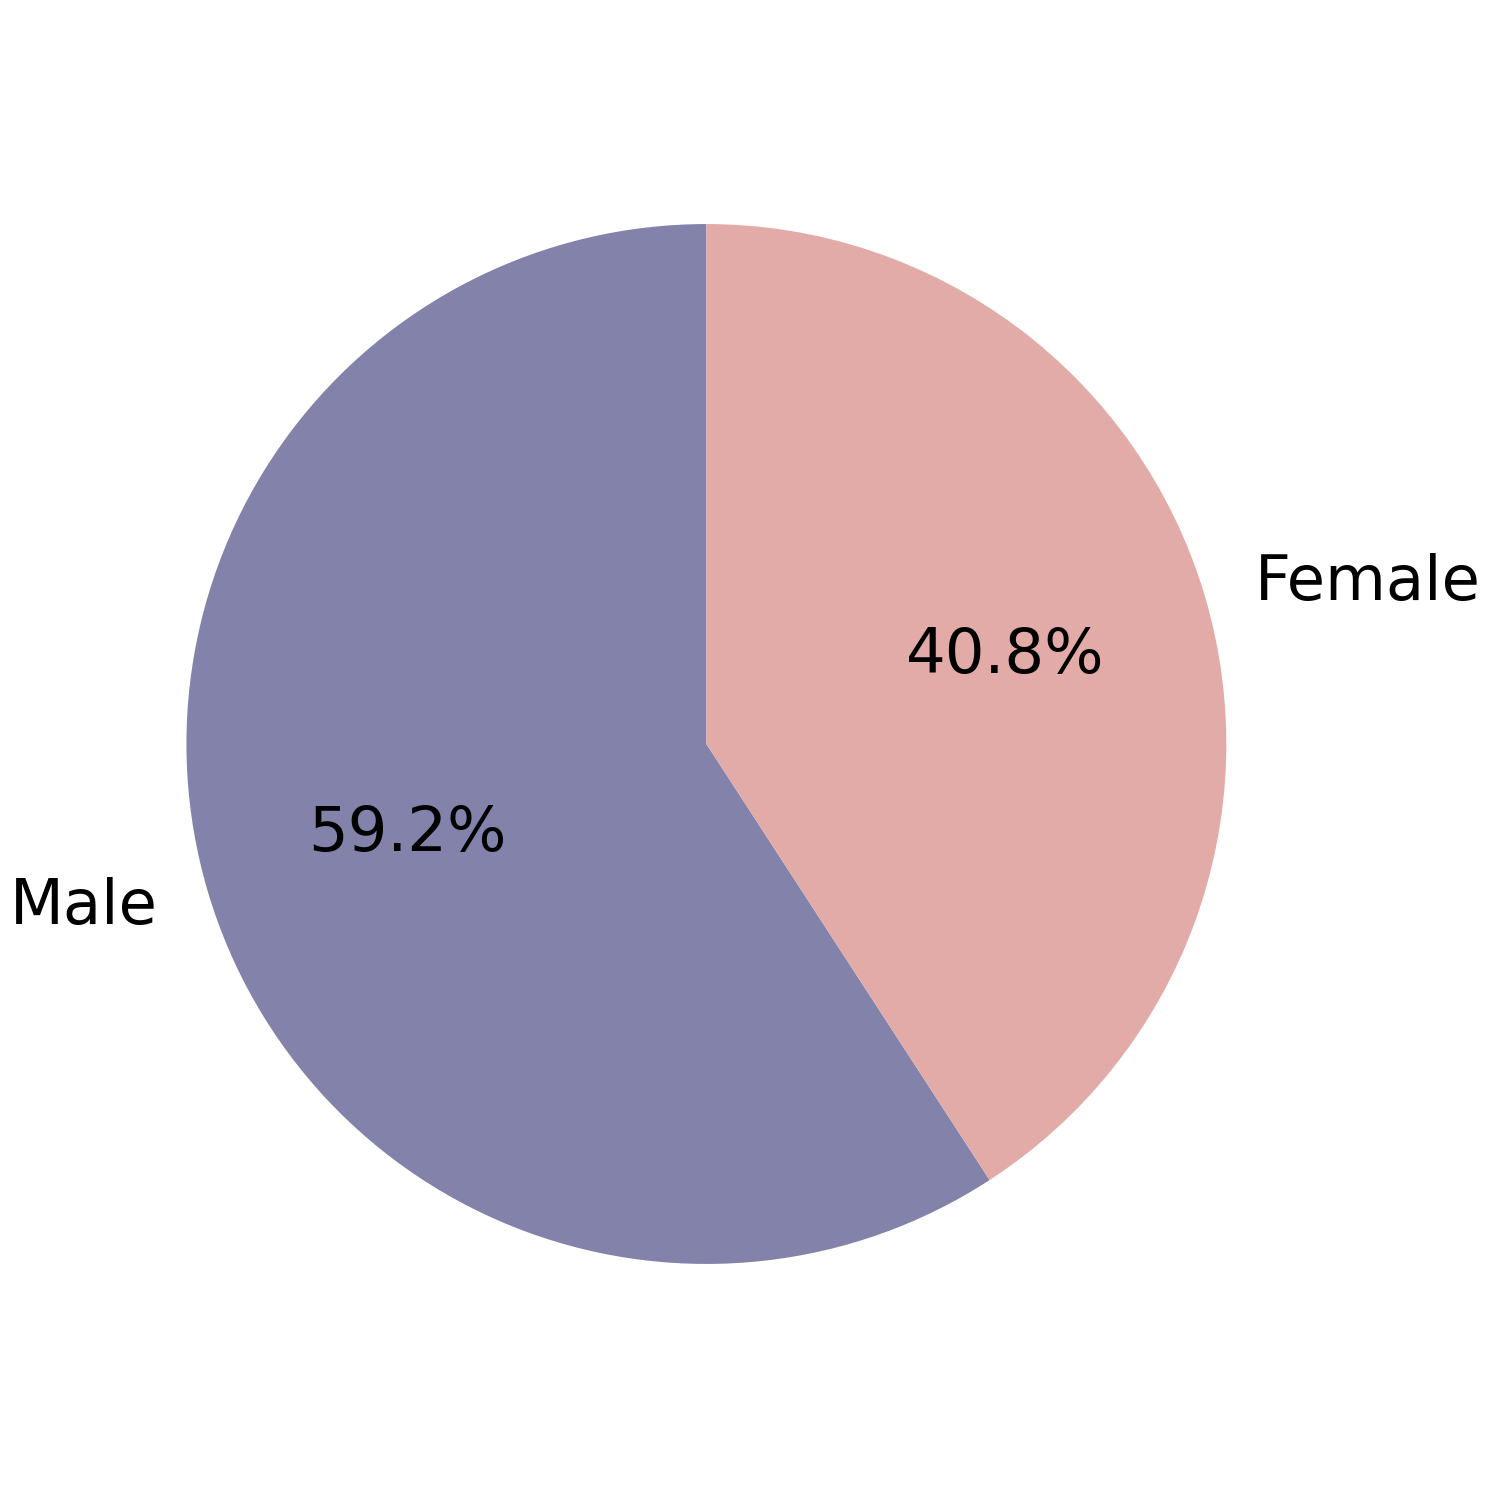

In [6]:
amos_counts = dict(amos_metadata["Patient's Sex"].value_counts())
totalseg_counts = dict(totalseg_metadata["gender"].value_counts())

colors = met_brew(name="Cassatt1", n=2, brew_type="colorblind")

plt.figure(figsize=(15, 15))
_, _, pie = plt.pie(np.array(list(amos_counts.values())) + np.array(list(totalseg_counts.values())), labels=['Male', 'Female'], autopct='%1.1f%%', pctdistance=0.6, colors=['#8282aa', '#e3aba7'], startangle=90, textprops={'fontsize': 45})

plt.setp(pie, **{'weight':'normal', 'fontsize':45})
plt.axis('equal')
plt.tight_layout()

plt.show()

## Organ Volumes

In [ ]:
nifti_images_dir = '/data/Dataset060_Merged_Def/labelsTr/'

organ_values = {
    1: 'Spl',
    2: 'RKid',
    3: 'LKid',
    4: 'Gall',
    5: 'Eso',
    6: 'Liv',
    7: 'Sto',
    8: 'Aor',
    9: 'IVC',
    10: 'Pan',
    11: 'RAG',
    12: 'LAG'
}

def calculate_volume(segmentation, organ_values, nifti_image):
    volumes = {}
    for value, organ_name in organ_values.items():
        pixel_count = np.count_nonzero(segmentation == value)

        if nifti_image.startswith('s'):
            volume_mm3 = pixel_count * np.prod((1.5, 1.5)) * 1.5
        else:
            volume_mm3 = pixel_count * np.prod((0.8, 0.8)) * 4
        

        if volume_mm3 > 0:
            volume_log3 = np.log(volume_mm3) / np.log(3)
        else:
            volume_log3 = 0  
        
        volumes[organ_name] = volumes.get(organ_name, 0) + volume_log3
    return volumes

df_organ_volumes = pd.DataFrame(columns=['Organ', 'Volume_mm3'])

for nifti_image in tqdm(os.listdir(nifti_images_dir)):
    if nifti_image.endswith('.nii') or nifti_image.endswith('.nii.gz'):
        nifti_path = os.path.join(nifti_images_dir, nifti_image)
        segmentation = nib.load(nifti_path).get_fdata()
        volumes = calculate_volume(segmentation, organ_values, nifti_image)
        
        for organ, volume in volumes.items():
            df_organ_volumes = pd.concat([df_organ_volumes, pd.DataFrame({'Organ': organ, 'Volume_mm3': volume}, index=[-1])], ignore_index=True)


Number of requested colors ('12') greater than number of colors 'Hokusai2' can offer. 
 Setting brew_type to 'continuous' instead.


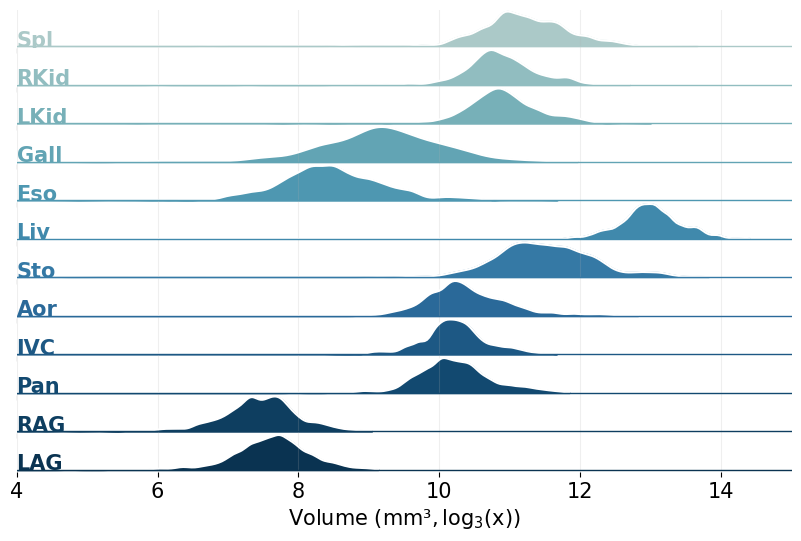

In [31]:
organs = df_organ_volumes['Organ'].unique()
num_organs = len(organs)

fontsize = 15

colors = met_brew(name="Hokusai2", n=12, brew_type="colorblind")

fig, axes = plt.subplots(num_organs, 1, figsize=(10, 0.5 * num_organs), sharex=True)

i = 0
for ax, organ in zip(axes, organs):
    organ_data = df_organ_volumes[df_organ_volumes['Organ'] == organ]
    volume_data = organ_data['Volume_mm3']
    
    # KDE plot
    density = gaussian_kde(volume_data, bw_method=0.15)
    x = np.linspace(2, volume_data.max(), 300)
    y = density(x)
    
    # Fill under the KDE curve
    ax.fill_between(x, y, color=colors[i], alpha=1)
    
    # Line around the KDE
    ax.plot(x, y, color="w", lw=1.5)
    
    # Add horizontal line and organ label
    ax.axhline(y=0, color=colors[i], linewidth=1)
    ax.text(4, 0, organ, fontweight="bold", color=colors[i], ha="left", fontsize=fontsize)
    
    # Remove y-axis labels and ticks
    ax.set_yticks([])
    ax.set_ylabel('')


    ax.grid(axis='x', alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


    i += 1

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.xlabel("Volume ($mm³, log_{3}(x)$)", fontsize=fontsize)

plt.subplots_adjust(hspace=0) 
plt.xlim(df_organ_volumes['Volume_mm3'].min(), df_organ_volumes['Volume_mm3'].max())

plt.xlim([4, 15])
plt.xticks(fontsize=fontsize)

plt.show()


## Manufacturer and Scanner Model

In [173]:
amos_metadata["Manufacturer"].unique()

array(['Philips', 'TOSHIBA', 'SIEMENS', 'GE MEDICAL SYSTEMS'],
      dtype=object)

In [174]:
totalseg_metadata["manufacturer"].unique()

array(['siemens', 'philips', 'ge', nan], dtype=object)

In [ ]:
totalseg_metadata["manufacturer"].replace('siemens', 'SIEMENS', inplace=True)
totalseg_metadata["manufacturer"].replace('philips', 'Philips', inplace=True)
totalseg_metadata["manufacturer"].replace('ge', 'GE MEDICAL SYSTEMS', inplace=True)

In [176]:
merged = pd.concat([amos_metadata["Manufacturer"], totalseg_metadata["manufacturer"]])

In [177]:
merged.replace('Philips', 'PHILIPS', inplace=True)

In [178]:
merged.value_counts()

SIEMENS               439
PHILIPS               127
TOSHIBA               101
GE MEDICAL SYSTEMS     26
Name: count, dtype: int64

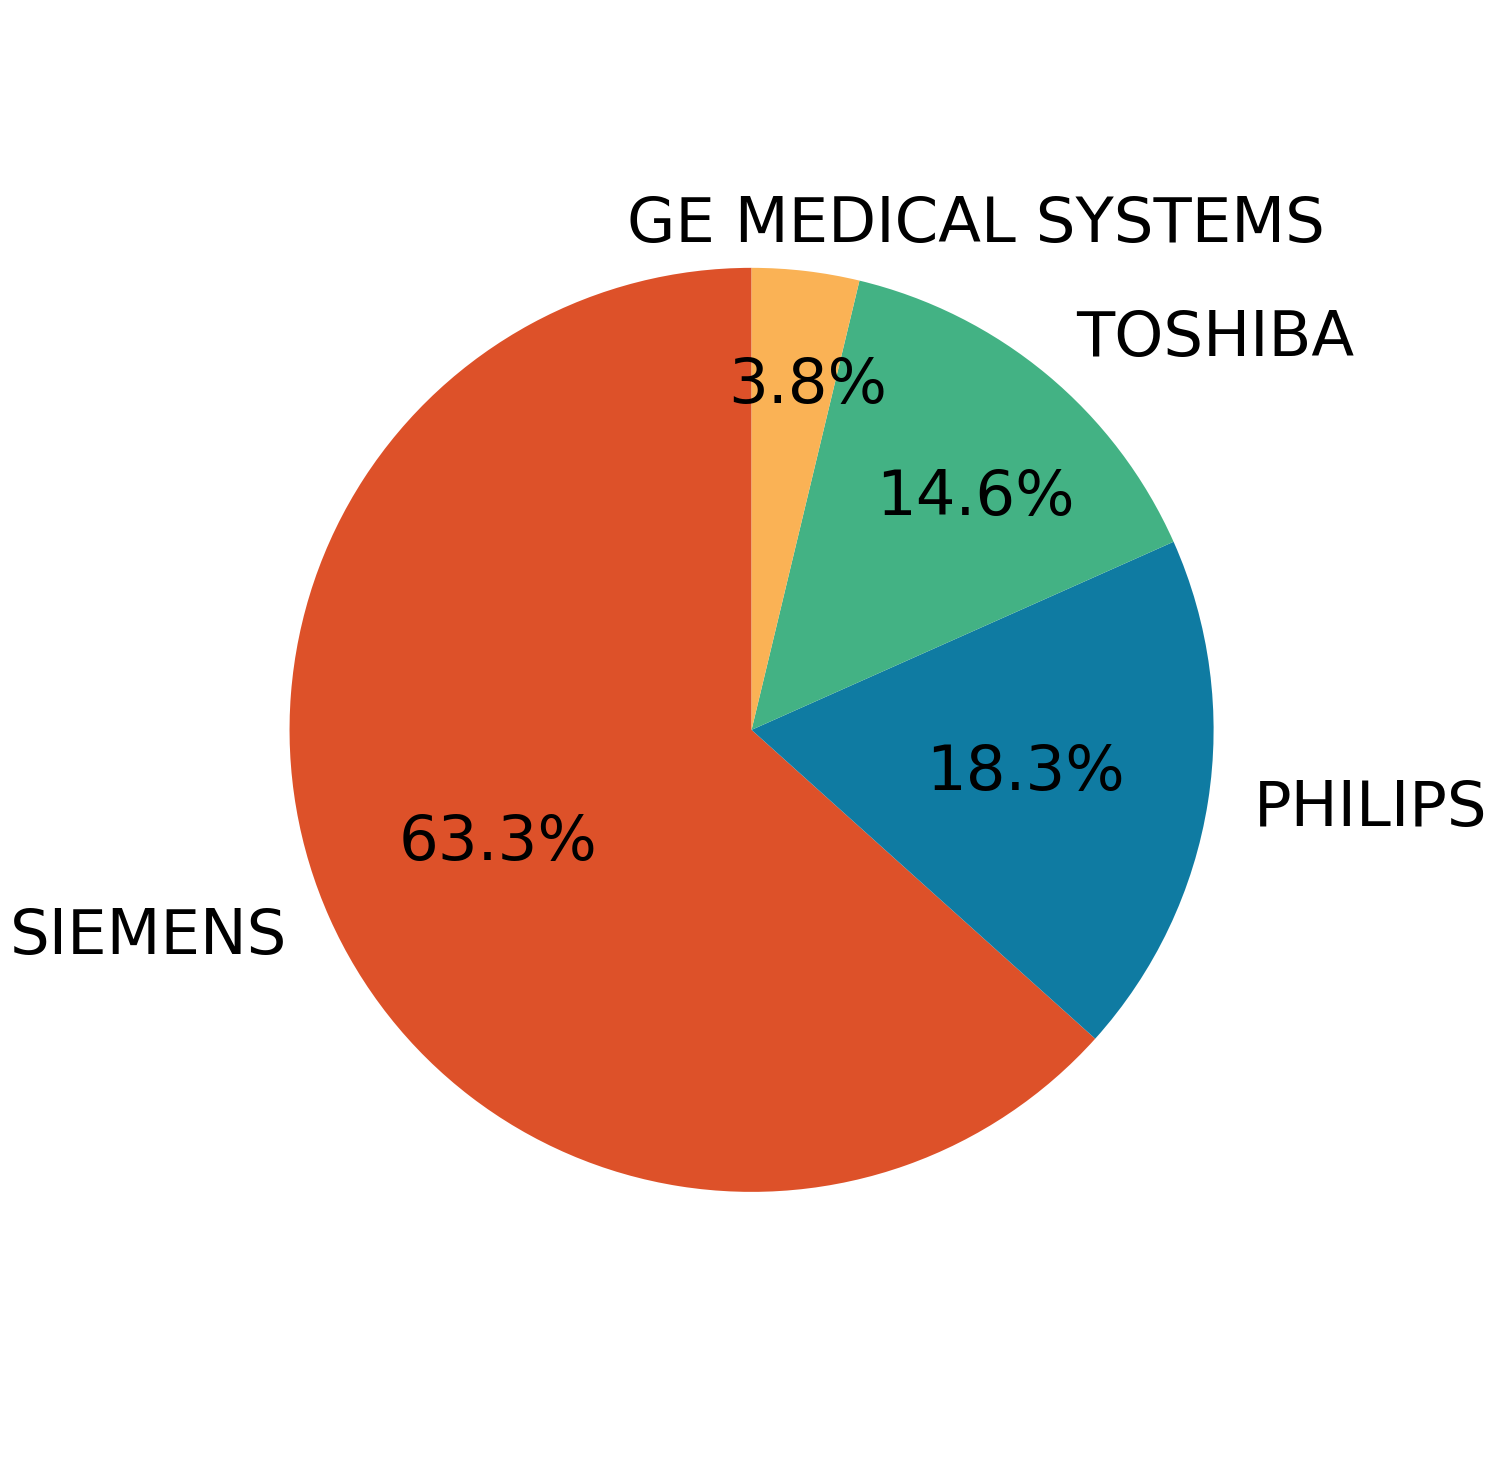

In [181]:
counts = dict(merged.value_counts())

colors = met_brew(name="Egypt", n=len(counts), brew_type="colorblind")

plt.figure(figsize=(15, 15))
_, labels, pie = plt.pie(counts.values(), labels=counts.keys(), autopct='%1.1f%%', pctdistance=0.6, colors=colors, startangle=90, textprops={'weight':'normal', 'fontsize': 45})


labels[3].set_x(np.array(labels[3].get_position())[0]-0.4)

pie[-2].set_y(np.array(pie[-2].get_position())[1]+0.04)
pie[-2].set_x(np.array(pie[-2].get_position())[0]+0.1)

pie[-1].set_y(np.array(pie[-1].get_position())[1]+0.15)
pie[-1].set_x(np.array(pie[-1].get_position())[0]+0.05)

plt.setp(pie, **{'weight':'normal', 'fontsize':45})
plt.axis('equal')
plt.tight_layout()

plt.show()

In [182]:
amos_metadata["Manufacturer's Model Name"].unique()

array(['Brilliance16', 'Aquilion ONE', 'SOMATOM Force', 'Prisma',
       'Ingenia', 'SIGNA HDe'], dtype=object)

In [183]:
totalseg_metadata["scanner_model"].unique()

array(['emotion 16', 'somatom definition flash', 'sensation 16',
       'somatom definition as+', 'sensation 64', 'iqon - spectral ct',
       'ingenuity core 128', 'lightspeed vct', 'somatom definition edge',
       'somatom force', 'somatom go.top', 'brilliance 64',
       'discovery ste', nan], dtype=object)

In [184]:
amos_metadata["Manufacturer's Model Name"].replace('SOMATOM Force', 'Somatom Force', inplace=True)

/tmp/ipykernel_224598/3686094358.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  amos_metadata["Manufacturer's Model Name"].replace('SOMATOM Force', 'Somatom Force', inplace=True)


In [185]:
totalseg_metadata["scanner_model"].replace('somatom force', 'Somatom Force', inplace=True)

/tmp/ipykernel_224598/2162333064.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  totalseg_metadata["scanner_model"].replace('somatom force', 'Somatom Force', inplace=True)


In [186]:
amos_metadata["Manufacturer's Model Name"].unique()

array(['Brilliance16', 'Aquilion ONE', 'Somatom Force', 'Prisma',
       'Ingenia', 'SIGNA HDe'], dtype=object)

In [187]:
totalseg_metadata["scanner_model"].unique()

array(['emotion 16', 'somatom definition flash', 'sensation 16',
       'somatom definition as+', 'sensation 64', 'iqon - spectral ct',
       'ingenuity core 128', 'lightspeed vct', 'somatom definition edge',
       'Somatom Force', 'somatom go.top', 'brilliance 64',
       'discovery ste', nan], dtype=object)

In [188]:
merged = pd.concat([amos_metadata["Manufacturer's Model Name"], totalseg_metadata["scanner_model"]])

In [189]:
merged.value_counts()

Somatom Force               132
Aquilion ONE                101
Brilliance16                 78
somatom definition flash     70
somatom definition as+       57
emotion 16                   50
Prisma                       40
somatom definition edge      37
ingenuity core 128           30
sensation 16                 26
lightspeed vct               20
somatom go.top               19
sensation 64                  8
Ingenia                       8
iqon - spectral ct            8
SIGNA HDe                     5
brilliance 64                 3
discovery ste                 1
Name: count, dtype: int64

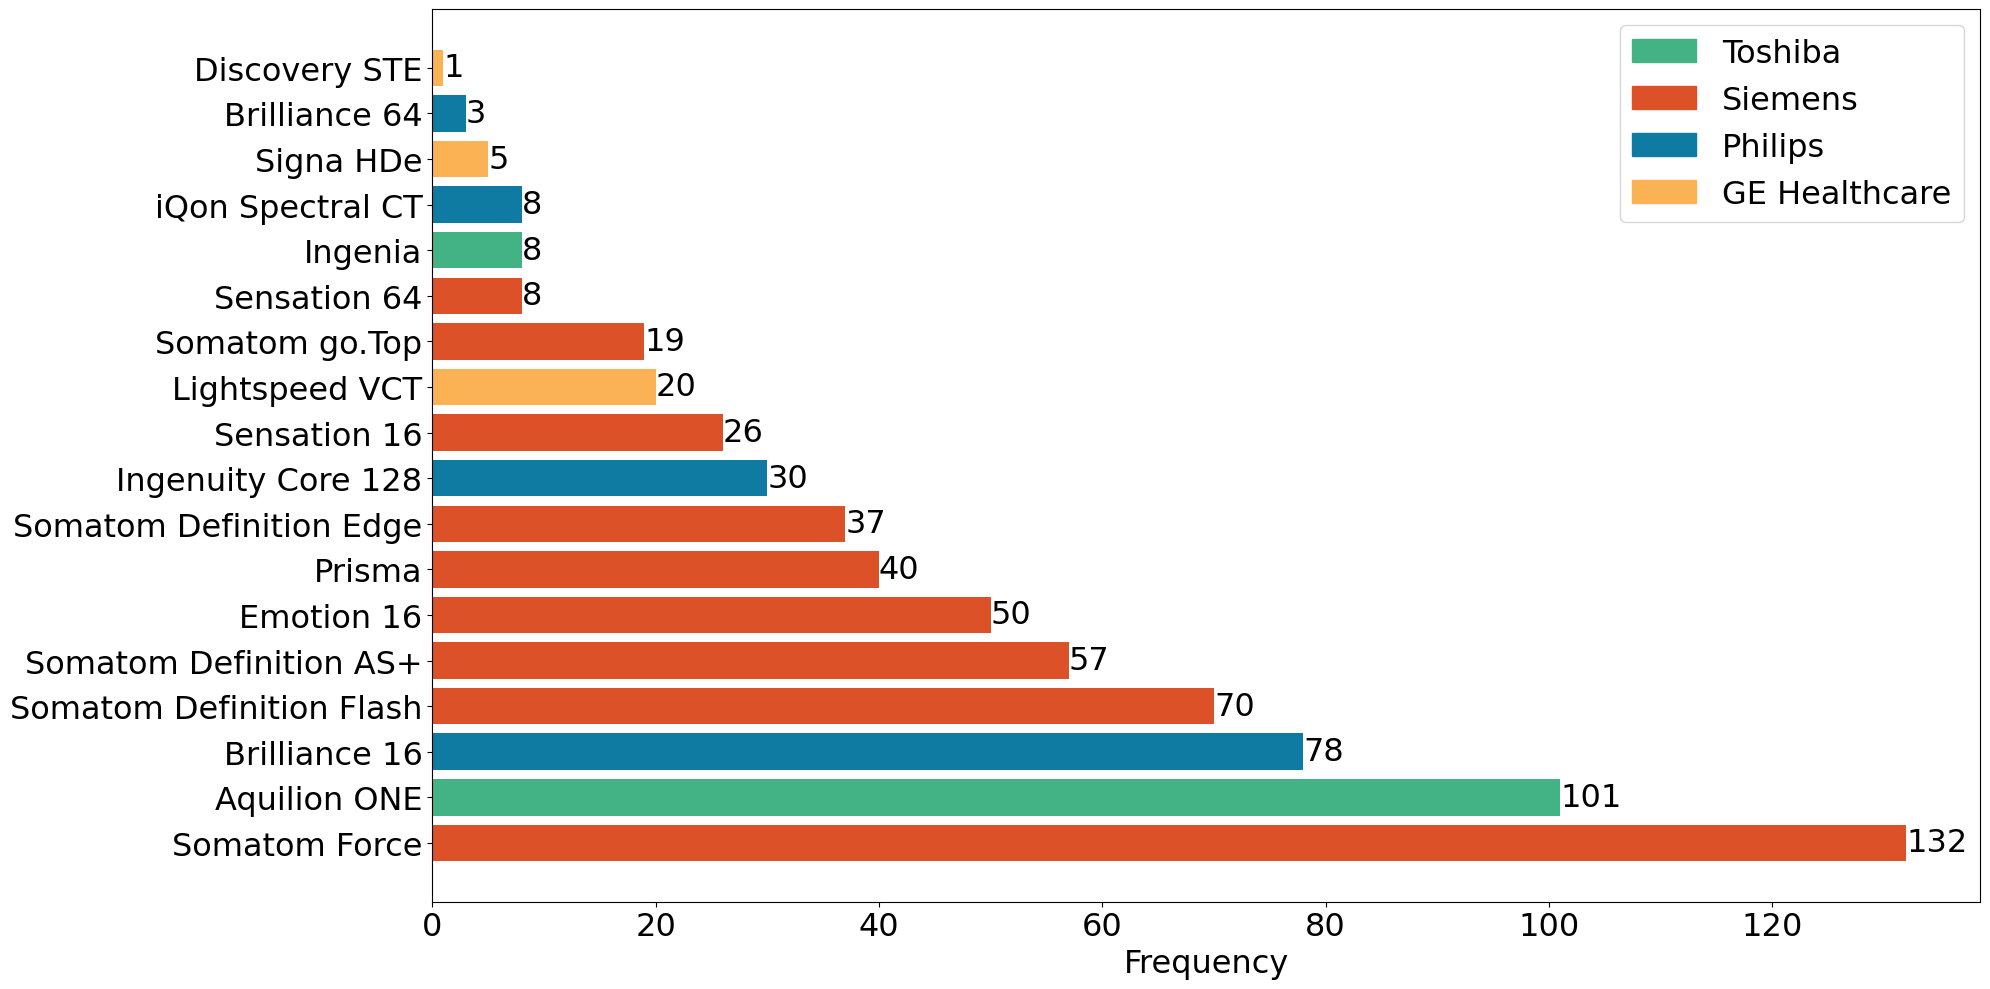

In [197]:
counts = dict(merged.value_counts())

fontsize = 23
colors = met_brew(name="Egypt", n=4, brew_type="colorblind")

plt.figure(figsize=(20, 10))
bars = plt.barh(width=counts.values(), y=list(counts.keys()), color=[colors[0], colors[2], colors[1], colors[0], 
colors[0], colors[0], colors[0], colors[0], colors[1], colors[0], colors[3], colors[0], colors[0], colors[2], 
colors[1], colors[3], colors[1], colors[3]])

legend_handles = [mpatches.Patch(color=colors[2], label='Toshiba'),
                  mpatches.Patch(color=colors[0], label='Siemens'),
                  mpatches.Patch(color=colors[1], label='Philips'),
                  mpatches.Patch(color=colors[3], label='GE Healthcare')]

ct_scanner_names = ['Discovery STE',
 'Brilliance 64',
 'Signa HDe',
 'iQon Spectral CT',
 'Ingenia',
 'Sensation 64',
 'Somatom go.Top',
 'Lightspeed VCT',
 'Sensation 16',
 'Ingenuity Core 128',
 'Somatom Definition Edge',
 'Prisma',
 'Emotion 16',
 'Somatom Definition AS+',
 'Somatom Definition Flash',
 'Brilliance 16',
 'Aquilion ONE',
 'Somatom Force']

plt.bar_label(bars, fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(ticks=range(len(ct_scanner_names)),labels=ct_scanner_names[::-1], fontsize=fontsize)
plt.xlabel('Frequency', fontsize=fontsize)
plt.legend(handles=legend_handles, fontsize=fontsize)
plt.tight_layout()

plt.show()

In [198]:
merged.value_counts()

Somatom Force               132
Aquilion ONE                101
Brilliance16                 78
somatom definition flash     70
somatom definition as+       57
emotion 16                   50
Prisma                       40
somatom definition edge      37
ingenuity core 128           30
sensation 16                 26
lightspeed vct               20
somatom go.top               19
sensation 64                  8
Ingenia                       8
iqon - spectral ct            8
SIGNA HDe                     5
brilliance 64                 3
discovery ste                 1
Name: count, dtype: int64

#### AGE

In [13]:
metadata = pd.concat([amos_metadata["Patient's Age"], totalseg_metadata["age"]])

In [14]:
metadata

0      069Y
1      068Y
2      093Y
3      067Y
4      043Y
       ... 
373    90.0
374    69.0
375    64.0
376    27.0
377    98.0
Length: 650, dtype: object

In [28]:
ages = np.array([])
for age in metadata:
    try:
        if age[-1] == 'Y':
            age = int(age[:-1])
        ages = np.append(ages, age)
    except:
        ages = np.append(ages, age)
        continue

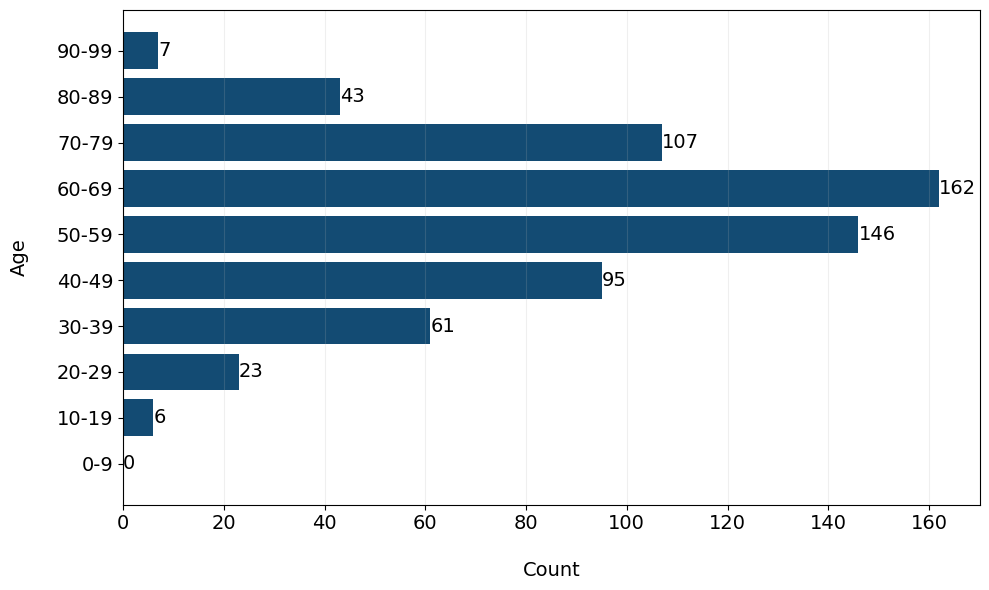

In [31]:
fontsize = 14
colors = met_brew(name="Hokusai2", n=1, brew_type="colorblind")

bin_edges = np.arange(0, 101, 10)

histogram, _ = np.histogram(ages, bins=bin_edges)

y_tick_labels = [f"{bin_edges[i]}-{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]

plt.figure(figsize=(10, 6))
bars = plt.barh(y_tick_labels, histogram, color=colors)
plt.xlabel('Count', fontsize=fontsize, labelpad=20)
plt.ylabel('Age', fontsize=fontsize, labelpad=20)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.grid(axis='x', alpha=0.2)
plt.bar_label(bars, fontsize=fontsize)
plt.tight_layout()

plt.show()
